In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install h2o4gpu

In [ ]:
import os
import re
import numpy as np
from osgeo import gdal
import cv2 as cv
from matplotlib import pyplot  as plt
from h2o4gpu.cluster import Birch
from h2o4gpu.solvers.kmeans import KMeans as kmeans
# from sklearn import cluster
import warnings
warnings.filterwarnings("ignore")
# import numba
from numba import jit

In [ ]:
############# This is the script for clustering in 4 class. it uses 4 band image and adds ndvi and ndwi

def sorted_aphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)
  
  
def get_all_images(folder, ext):

    all_files = []
    fname = []
    #Iterate through all files in folder
    for file in sorted_aphanumeric(os.listdir(folder)):
        #Get the file extension
        basename,  file_ext = os.path.splitext(file)

        #If file is of given extension, get it's full path and append to list
        if ext in file_ext:
            full_file_path = os.path.join(folder, file)
            all_files.append(full_file_path)
            fname.append(basename)
    #Get list of all files
    return all_files,fname

def rint(k):
    
    np.random.seed(40)
    
    clr = np.random.randint(low = 0, high = 255, size = (k,3))
    # clr is a tuple
    return clr
"""
def change_color_scheme(img, center, color_tuple)
    assert len(center)==len(color_tuple)
    for c in range(len(center)):
        center[c,:]= color_tuple[c,:]
    return center
"""     
def raster2array(raster, bnd,x,y,wndox, wndoy):
    rr = np.zeros((wndoy, wndox, bnd))
    newValue = 0
    for b in range(bnd):
        band = raster.GetRasterBand(b+1)
        rr[:,:,b] = band.ReadAsArray(x, y, wndox, wndoy)
        noDataValue = band.GetNoDataValue()
    rr[rr == noDataValue] = newValue
    return rr.astype(np.uint8)
        
def visual(h, w, i, img ):
    fig = plt.figure(figsize=(2, 2), dpi=512)
    ax = plt.subplot(h, w, i)
    ax.set_xticks([])
    ax.set_yticks([])
    #ax.title.set_text('images_{}'.format(i-1))
    plt.imshow(img, cmap = 'jet')

def process_kmeans(imgn, K):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 0.05)
    # Set flags (Just to avoid line break in the code)
    flags = cv.KMEANS_RANDOM_CENTERS  
    img1 = imgn.reshape((-1,imgn.shape[-1]))
    img1 = np.float32(img1)
    compactness,label,center = cv.kmeans(img1, K,None,criteria,30,flags)
    center = np.uint8(center)
    #cent = rint(K)
    cent = cr
    res = cent[label.flatten()]
    res2 = res.reshape((imgn.shape[0],imgn.shape[1],3))
    return res2
cr = np.zeros((4,3))
cr[0,0] = 255
cr[1,1]= 255
cr[2,2] = 255
cr[3,:]= 255

def process_kmeans2(imgn, K):
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 0.05)
    # Set flags (Just to avoid line break in the code)
    flags = cv.KMEANS_RANDOM_CENTERS  
    img1 = imgn.reshape((-1,imgn.shape[-1]))
    img1 = np.float32(img1)
    compactness,label,center = cv.kmeans(img1, K,None,criteria,30,flags)
    # center = np.uint8(center)
    #cent = rint(K)
    # cent = cr
    # res = cent[label.flatten()]
    # res2 = res.reshape((imgn.shape[0],imgn.shape[1],3))
    return label.reshape((imgn.shape[0],imgn.shape[1]))

def process_kmeans_gpu(imgn, K):
    img1 = imgn.reshape((-1,imgn.shape[-1]))
    # img1 = np.float32(img1)
    img1 = np.uint64(img1)
    kmn = kmeans(n_clusters=K,init='k-means++', n_init=10, max_iter=10, tol=0.05, precompute_distances='auto', verbose=0, random_state=36, copy_x=True, n_jobs=None, algorithm='auto').fit(img1)
    # kmn = kmeans(n_clusters=K,init=initc, n_init=10, max_iter=10, tol=0.05, precompute_distances='auto', verbose=0, random_state=36, copy_x=True, n_jobs=None, algorithm='auto').fit(img1)
    label = kmn.labels_
    
    return label.reshape((imgn.shape[0],imgn.shape[1]))



def normalize_predictions(predictions):
    """
    We take the assumption that the data set contains less than 50 % of outlier.
    Given that the classifier, gives the label 0 and 1 for the same data
    randomly. We make sure that an inlier is described as a 0.

    :param predictions:  A 1 D numpy array with the predictions of our detector
    :return: predictions: A 1 D numpy array with the predictions of our detector, cleaned
    """
    if np.sum(predictions) > (len(predictions) / 2 - 1):
        predictions = 1 - predictions

    return predictions


def detection_with_birch(image):
    """
    
    :param image_set: The bottleneck values of the relevant images.
    :return: Predictions vector
    """
    h,w = image.shape[:2]
    image = image.reshape(-1,image.shape[-1])
    # The branching_factor, might be fine tune for better results
    # clf = cluster.Birch(threshold = 10,n_clusters=10,copy = True)
    # clf = bir(threshold = 10,n_clusters=10,copy = True)
    clf = Birch(threshold = 1.7, copy=True)
    clf.fit(image)

    predictions = clf.labels_
    # predictions = normalize_predictions(predictions)
    centroids = clf.subcluster_centers_
    return predictions.reshape(h,w),centroids

# fpath = '/content/drive/My Drive/Excel/vietnam images/t48pws_20190215_re.img'
# fpath = '/content/drive/My Drive/Excel/vietnam images/t48pwr_20180312_re.img'
# #fpath = '/content/drive/MyDrive/Portugal/portugal_image_16bit_rescaled.tif'
# fpath = '/content/drive/MyDrive/portugal_full_image_8bit.tif'


def norm_classes(img1,img2,ndvi,ndwi,nClasses):
    for c in list(set(img1.flatten())):    
        mask = np.zeros_like(img1)
        mask[img1==c] =1
        mean_ndvi = np.sum(ndvi[img1==c])/np.sum(mask)
        mean_ndwi = np.sum(ndwi[img1==c])/np.sum(mask)
        if (mean_ndvi<0.2 and mean_ndvi>0 and mean_ndwi<0.1):
            img2[img1==c] = 7
        elif (mean_ndvi<0.4 and mean_ndvi>=0.2 and mean_ndwi<0.1):
            img2[img1==c] = 8
        elif (mean_ndvi>=0.4 and mean_ndwi<0.1):
            img2[img1==c] = 9
        elif (mean_ndvi<0.1 and mean_ndwi>=0.3):
            img2[img1==c] = 1 
        elif (mean_ndvi<0.1 and mean_ndwi<0.3 and mean_ndwi>0.1):
            img2[img1==c] = 2 
        elif (mean_ndvi<0.1 and mean_ndwi<0.1):
            img2[img1==c] = 3
        elif (mean_ndvi<=0.2 and mean_ndvi>0.1 and mean_ndwi<=0.3 and mean_ndwi>0.1):
            img2[img1==c] = 4 
        elif (mean_ndvi<=0.4 and mean_ndvi>0.2 and mean_ndwi<=0.3 and mean_ndwi>0.1):
            img2[img1==c] = 5 
        else:
            img2[img1==c] = 6
    return img2

# def norm_classes(img1,img2,ndvi,ndwi,nClasses):
#     for c in list(set(img1.flatten())):    
#         mask = np.zeros_like(img1)
#         mask[img1==c] =1
#         mask_ndvi = ndvi*mask
#         mask_ndwi = ndwi*mask
#         mask_ndvi = np.ravel(mask_ndvi[mask_ndvi!=0])
#         mask_ndwi = np.ravel(mask_ndwi[mask_ndwi!=0])
#         if ((len(mask_ndvi)==0) | (len(mask_ndwi)==0)):
#             img2[img1==c] = 0
#         else:
#             mean_ndvi = np.mean(mask_ndvi)
#             mean_ndwi = np.mean(mask_ndwi)
#             std_ndvi = 0 #0.01*np.std(mask_ndvi)
#             std_ndwi = 0 #0.01*np.std(mask_ndwi)
        
#             if (mean_ndvi<0.2+std_ndvi and mean_ndvi>-std_ndvi and mean_ndwi<std_ndwi):
#                 img2[img1==c] = 7
#             elif (mean_ndvi<0.4+std_ndvi and mean_ndvi>=0.2-std_ndvi and mean_ndwi<std_ndwi):
#                 img2[img1==c] = 8
#             elif (mean_ndvi>=0.4-std_ndvi):
#                 img2[img1==c] = 9
#             elif (mean_ndwi>=0.3-std_ndwi):
#                 img2[img1==c] = 1 
#             elif (mean_ndvi<std_ndvi and mean_ndwi<0.3+std_ndwi and mean_ndwi>-std_ndwi):
#                 img2[img1==c] = 2 
#             elif (mean_ndvi<std_ndvi and mean_ndwi<std_ndwi):
#                 img2[img1==c] = 3
#             elif (mean_ndvi<=0.2+std_ndvi and mean_ndvi>-std_ndvi and mean_ndwi<=0.3+std_ndwi and mean_ndwi>-std_ndwi):
#                 img2[img1==c] = 4 
#             elif (mean_ndvi<=0.4+std_ndvi and mean_ndvi>0.2-std_ndvi and mean_ndwi<=0.3+std_ndwi and mean_ndwi>-std_ndwi):
#                 img2[img1==c] = 5 
#             else:
#                 img2[img1==c] = 6
#     return img2


def add_veg_water_index(image):
    # raster = gdal.Open(fpath)
    # w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    # ##########image1 = (raster2array(raster,4,0,0,w,h)).astype(np.uint8)
    # image = (raster2array(raster,4,0,0,w,h)).astype(np.uint8)
    # raster = None       
    h,w = image.shape[:2]
    b,g,r,nir = cv.split(image)
    
    # image2= np.zeros((h,w,6))
    # image2[:,:,:4] = image
    # del image
    # r = image2[:,:,2]
    # g = image2[:,:,1]
    # nir = image2[:,:,3]
     
    # num1 = nir-r
    # dnm1 = nir+r
    # num2= g-nir
    # dnm2 = g+nir
    
    # del nir,r,g
    ndvi = np.divide((nir-r),(nir+r), where = ((nir+r)!=0), dtype = np.float64)
    ndwi = np.divide((g-nir),(g+nir), where = ((nir+g)!=0), dtype = np.float64)
    ndvi[(b==0)&(g==0)&(r==0)&(nir==0)] =0
    ndwi[(b==0)&(g==0)&(r==0)&(nir==0)] =0
    # del num1,num2,dnm1,dnm2
    # ndvi[(image2[:,:,0]==0) & (image2[:,:,1]==0) & (image2[:,:,2]==0) & (image2[:,:,3]==0)] = 0
    # ndwi[(image2[:,:,0]==0) & (image2[:,:,1]==0) & (image2[:,:,2]==0) & (image2[:,:,3]==0)] = 0
    ndvi[ndvi>1] = 0
    ndvi[ndvi<-1] = 0
    ndwi[ndwi>1] = 0
    ndwi[ndwi<-1] = 0
    
    
    '''
    ndvi[ndvi>=0.2] = 100
    ndvi[ndvi<0.2] = 0
    ndwi[ndwi>=0.3] = 200
    ndwi[ndwi<0.3] = 0
    '''
    # image2[:,:,4] = 127.5 + ndvi*127.5
    ndvi_r = 127.5 + ndvi*127.5
    ndwi_r = 127.5 + ndwi*127.5
    # image2[:,:,5] = 127.5 + ndwi*127.5

    # image2[:,:,4] = 500 + ndvi*500
    # image2[:,:,5] = 500 + ndwi*500

    # image2[:,:,6] = np.ones((256,256))*np.array(list(range(256))).reshape(256,1) -128
    # image2[:,:,7] = np.ones((256,256))*np.array(list(range(256))).reshape(1,256) -128
    # del ndvi,ndwi
    return np.concatenate((b.reshape(h,w,1),g.reshape(h,w,1),r.reshape(h,w,1),nir.reshape(h,w,1),ndvi_r.reshape(h,w,1),ndwi_r.reshape(h,w,1)),axis =2),ndvi,ndwi
'''
image2,h,w = add_veg_water_index(fpath) 

##visual(1,2,1,image2[:1024,:1024,1:4])


size = 256
ints1 = list(range(0,h+1,size))
ints2 = list(range(0,w+1,size))
i = len(ints1)
j = len(ints2)
   

m=1
for k in ints1[0:-1]:
    img = np.zeros((size,size,3))
    for n in ints2[0:-1]:
        img = image2[k:(k+size), n:(n+size),:]
        img = process_kmeans2(img,4)
        image[k:(k+size), n:(n+size),:] = img
    print("\r", m, '/',(i-1), end=" ")
    m+=1

cv.imwrite('/content/gdrive/My Drive/Excel/namibia_re_kmeans.jpg', image)
print('image saved')
'''


'\nimage2,h,w = add_veg_water_index(fpath) \n\n##visual(1,2,1,image2[:1024,:1024,1:4])\n\n\nsize = 256\nints1 = list(range(0,h+1,size))\nints2 = list(range(0,w+1,size))\ni = len(ints1)\nj = len(ints2)\n   \n\nm=1\nfor k in ints1[0:-1]:\n    img = np.zeros((size,size,3))\n    for n in ints2[0:-1]:\n        img = image2[k:(k+size), n:(n+size),:]\n        img = process_kmeans2(img,4)\n        image[k:(k+size), n:(n+size),:] = img\n    print("\r", m, \'/\',(i-1), end=" ")\n    m+=1\n\ncv.imwrite(\'/content/gdrive/My Drive/Excel/namibia_re_kmeans.jpg\', image)\nprint(\'image saved\')\n'

In [ ]:
def batch_predict(fpath,hi,wi):
    raster = gdal.Open(fpath)
    w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    # w,h = 1200,1200
    size = 256
    nClasses =20

    # h,w = 1024,1024
    ints1 = list(range(hi,h+1,size))
    ints2 = list(range(wi,w+1,size))
    i = len(ints1)
    j = len(ints2)
    image = np.zeros((h,w,1))
    m=1
    for k in ints1[0:-1]:
        img = np.zeros((size,size,4))
        img1 = np.zeros((size,size))
        img2 = np.zeros((size,size))
        for n in ints2[0:-1]:
            # img[size//2:3*size//2,size//2:3*size//2,:] = raster2array(raster,4,n,k,size,size)
            img = raster2array(raster,4,n,k,size,size)
                
            image2,ndvi,ndwi = add_veg_water_index(img)
            
            # img1,centre = detection_with_birch(image2)
            # nClasses = np.unique(image3).size
            img1 = process_kmeans_gpu(image2,nClasses)
            
            # img1 = detection_with_birch(image2)
            # ndvi_list =[]
            # ndwi_list =[]

            img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)
            img2[(img[:,:,0]==0)&(img[:,:,1]==0)&(img[:,:,2]==0)&(img[:,:,3]==0)]=0
            image[k:(k+size), n:(n+size),0] = img2
            # image[k:(k+size), n:(n+size),0] = img2[size//2:3*size//2,size//2:3*size//2]

        print("\r", m, '/',i-1, end=" ")
        m+=1

    for k in ints1[0:-1]:
        img1 = np.zeros((size,size))
        img2 = np.zeros((size,size))

        img = raster2array(raster,4,(w-size),k,size,size)
        image2,ndvi,ndwi = add_veg_water_index(img)
        # img1,centre = detection_with_birch(image2)
        # nClasses = np.unique(image3).size
        img1 = process_kmeans_gpu(image2,nClasses)
        # img1 = detection_with_birch(image2)
        # ndvi_list =[]
        # ndwi_list =[]

        img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)
        img2[(img[:,:,0]==0)&(img[:,:,1]==0)&(img[:,:,2]==0)&(img[:,:,3]==0)]=0
        image[k:(k+size), (w-size):w,0] = img2

    for n in ints2[0:-1]:
        img1 = np.zeros((size,size))
        img2 = np.zeros((size,size))

        img = raster2array(raster,4,n,h-size,size,size)
        image2,ndvi,ndwi = add_veg_water_index(img)
        # img1,centre = detection_with_birch(image2)
        # nClasses = np.unique(image3).size
        img1 = process_kmeans_gpu(image2,nClasses)
        # img1 = detection_with_birch(image2)
        # ndvi_list =[]
        # ndwi_list =[]

        img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)
        img2[(img[:,:,0]==0)&(img[:,:,1]==0)&(img[:,:,2]==0)&(img[:,:,3]==0)]=0
        image[(h-size):h, n:(n+size),0] = img2

    img1 = np.zeros((size,size))
    img2 = np.zeros((size,size))

    img = raster2array(raster,4,w-size,h-size,size,size)
    image2,ndvi,ndwi = add_veg_water_index(img)
    # img1,centre = detection_with_birch(image2)
    # nClasses = np.unique(image3).size
    img1 = process_kmeans_gpu(image2,nClasses)
    # img1 = detection_with_birch(image2)
    # ndvi_list =[]
    # ndwi_list =[]

    img2 = norm_classes(img1,img2,ndvi,ndwi,nClasses)
    
    img2[(img[:,:,0]==0)&(img[:,:,1]==0)&(img[:,:,2]==0)&(img[:,:,3]==0)]=0
    image[(h-size):h, (w-size):w,0] = img2

    raster=None
    return image

size = 256
folder_img = '/content/drive/My Drive/Excel/vietnam images'
# folder_img = '/content/drive/My Drive/Portugal/sentinel'
flist,fnamelist = ((get_all_images(folder_img, 'img')))

for f, fns in enumerate(flist[5:6]):
    f=f+5
    image = batch_predict(fns,0,0)
    
    print("predicted 1/4")
    # image2 = batch_predict(fns,size//2,0)
    # print("predicted 2/4")

    # image3 = batch_predict(fns,0,size//2)
    # print("predicted 3/4")

    # image4 = batch_predict(fns,size//2,size//2)
    # print("predicted 4/4")

    # h,w = image.shape[:2]
    # ints1 = list(range(0,h+1,size))
    # ints2 = list(range(0,w+1,size))

    # i = len(ints1)
    # j = len(ints2)

    # m=1
    # for k in ints1[0:-1]:
    #     image[(k-size//4):(k+size//4),:] = image2[(k-size//4):(k+size//4),:]
    #     #image[(k-10):(k+10),:] = image2[(k-10):(k+10),:]   
    # for n in ints2[0:-1]:
    #     image[:, (n-size//4):(n+size//4)] = image3[:, (n-size//4):(n+size//4)]
    #     #image[:, (n-10):(n+10)] = image3[:, (n-10):(n+10)]        
    # for k in ints1[0:-1]:
    #     for n in ints2[0:-1]:
    #         image[(k-size//4):(k+size//4),(n-size//4):(n+size//4)] = image4[(k-size//4):(k+size//4),(n-size//4):(n+size//4)]
    # del image2,image3,image4
    print('0123456789: ',  np.sum((image[image==0])+1), np.sum((image[image==1])), np.sum((image[image==2])/2), np.sum((image[image==3])/3), np.sum((image[image==4])/4),np.sum((image[image==5])/5),np.sum((image[image==6])/6),np.sum((image[image==7])/7),np.sum((image[image==8])/8),np.sum((image[image==9])/9))
    cv.imwrite('/content/drive/MyDrive/Excel/kmean_gpu_pred1/{}_landsat_pred1.tif'.format(fnamelist[f]), image.astype(np.uint8))

    print('image {} saved'.format(f))
    # del image

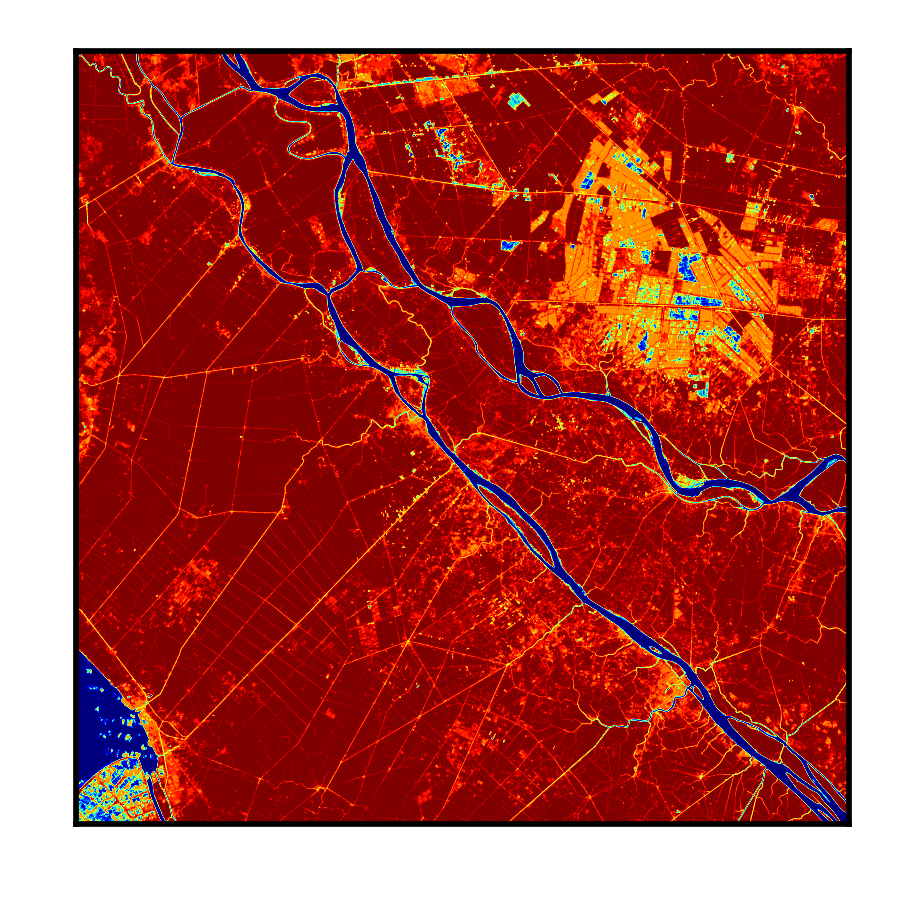

In [ ]:

# visual(1,1,1,image.reshape((image.shape[0],image.shape[1])))
visual(1,1,1,np.squeeze(image))

In [ ]:
visual(1,1,1,image.reshape((10980,10980)))

ValueError: ignored

In [ ]:
folder_img = '/content/drive/My Drive/Excel/vietnam test images'
flist,fnamelist = ((get_all_images(folder_img, 'img')))
folder_label = '/content/drive/My Drive/Excel/kmeans_gpu'
flist2,fnamelist2 = ((get_all_images(folder_label, 'tif')))
nClasses =10
for f in range(len(flist[:6])):
    raster = gdal.Open(flist[f])
    w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    image = raster2array(raster,4,0,0,w,h)
    raster = None
    b,g,r,nir = cv.split(image)
    del image
    num1 = nir-r
    dnm1 = nir+r
    num2= g-nir
    dnm2 = g+nir
    
    ndvi = np.divide(num1,dnm1, where = (dnm1!=0), dtype = np.float64)
    ndwi = np.divide(num2,dnm2, where = (dnm2!=0), dtype = np.float64)
    
    del num1,num2,dnm1,dnm2
    ndvi[(b==0) & (g==0) & (r==0) & (nir==0)] = 0
    ndwi[(b==0) & (g==0) & (r==0) & (nir==0)] = 0
    ndvi[ndvi>1] = 0
    ndvi[ndvi<-1] = 0
    ndwi[ndwi>1] = 0
    ndwi[ndwi<-1] = 0
    
    del nir,r,g,b
    
    raster = gdal.Open(flist2[f])
    w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    label = raster2array(raster,1,0,0,w,h).reshape((h,w))
    raster = None
    mean_ndvi =[]
    mean_ndwi =[]
    for c in range(nClasses):
        mean_ndvi.append(np.mean(ndvi[label==c]))
        mean_ndwi.append(np.mean(ndwi[label==c]))
    print('Image: ', f)
    print('ndvi: ',mean_ndvi)
    print('ndwi: ',mean_ndwi)

Image:  0
ndvi:  [0.0, 0.00049108113984012, 0.0020531106134718882, 0.00174090561216389, 0.05250198228323969, 0.20537607466190747, 0.0, 0.11068248333228656, 0.2905453856691787, 0.6240130009997384]
ndwi:  [0.0, 0.3422937895353107, 0.1250481289108392, 0.0015905354275793883, 0.1739860376843156, 0.07865737021368631, 0.0, 0.017551141538705788, 0.001515583204184187, 9.746506013757305e-06]
Image:  1
ndvi:  [0.0, 5.428802089029034e-09, 4.5865288238595446e-06, 0.006903722933154782, 0.0, 0.0, 0.0, 0.11327979012364811, 0.2859760195484072, 0.511643530153291]
ndwi:  [0.0, 0.32864869970291977, 0.22654609267454073, 0.009687681642362927, 0.0, 0.0, 0.0, 0.003335775132065254, 0.0004723834905554619, 0.0015639400306999526]
Image:  2
ndvi:  [0.0, 0.00017789628435731014, 0.0027835753471310313, 0.018085333078815134, 0.005691426548011337, 0.24962532395225862, 1.725620865281347e-06, 0.11848133557314348, 0.2806557978158598, 0.7036719454098103]
ndwi:  [0.0, 0.4778751853247702, 0.14942115315187757, 0.0200407311939

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Image:  3
ndvi:  [0.0, 1.958075090185559e-08, 0.005531157436871023, 0.01415596928152287, 0.01659326347127244, nan, 0.0, 0.14350807485334097, 0.3174739498733043, 0.44163545507367025]
ndwi:  [0.0, 0.42149852320387704, 0.2105750617673758, 0.0053608050576581575, 0.012562372551645228, nan, 0.0, 0.01454954648613283, 0.0001678236176424316, 5.452514113619197e-07]
Image:  4
ndvi:  [0.0, 5.805647859365356e-08, 0.0041853940824879265, 0.019437437680269665, 0.04070749785036309, nan, 0.0, 0.11546852145681882, 0.298744787006234, 0.5642484224505014]
ndwi:  [0.0, 0.48224888797926563, 0.1605611113176437, 0.017966795347597885, 0.042203571182633265, nan, 0.0, 0.0048708992735453345, 0.00013585269844221235, 7.216585094917985e-08]
Image:  5
ndvi:  [nan, 0.00044316175229398787, 0.012163010600160557, nan, 0.09825512349859448, 0.2319018001165829, nan, 0.15345324224941226, 0.31341906610477144, 0.6242584015181085]
ndwi:  [nan, 0.48345309019734983, 0.221857598407472, nan, 0.06714698367214474, 0.03742919655226868, 

In [ ]:
size = 256
# image2 = batch_predict(size//2,0)
# print("predicted 2")

# image3 = batch_predict(0,size//2)
# print("predicted 3")

# image4 = batch_predict(size//2,size//2)
# print("predicted 4")
h,w = image.shape[:2]
ints1 = list(range(0,h+1,size))
ints2 = list(range(0,w+1,size))

i = len(ints1)
j = len(ints2)
m=1
for k in ints1[0:-1]:
    image[(k-size//4):(k+size//4),:] = image2[(k-size//4):(k+size//4),:]
    #image[(k-10):(k+10),:] = image2[(k-10):(k+10),:]   
for n in ints2[0:-1]:
    image[:, (n-size//4):(n+size//4)] = image3[:, (n-size//4):(n+size//4)]
    #image[:, (n-10):(n+10)] = image3[:, (n-10):(n+10)]        
for k in ints1[0:-1]:
    for n in ints2[0:-1]:
        image[(k-size//4):(k+size//4),(n-size//4):(n+size//4)] = image4[(k-size//4):(k+size//4),(n-size//4):(n+size//4)]
cv.imwrite('/content/drive/My Drive/portugal_rescaled_pred.tif', image.astype(np.uint8))

NameError: ignored

In [ ]:
print(set(image.flatten()))

{1.0, 2.0, 4.0, 5.0, 7.0, 8.0, 9.0}


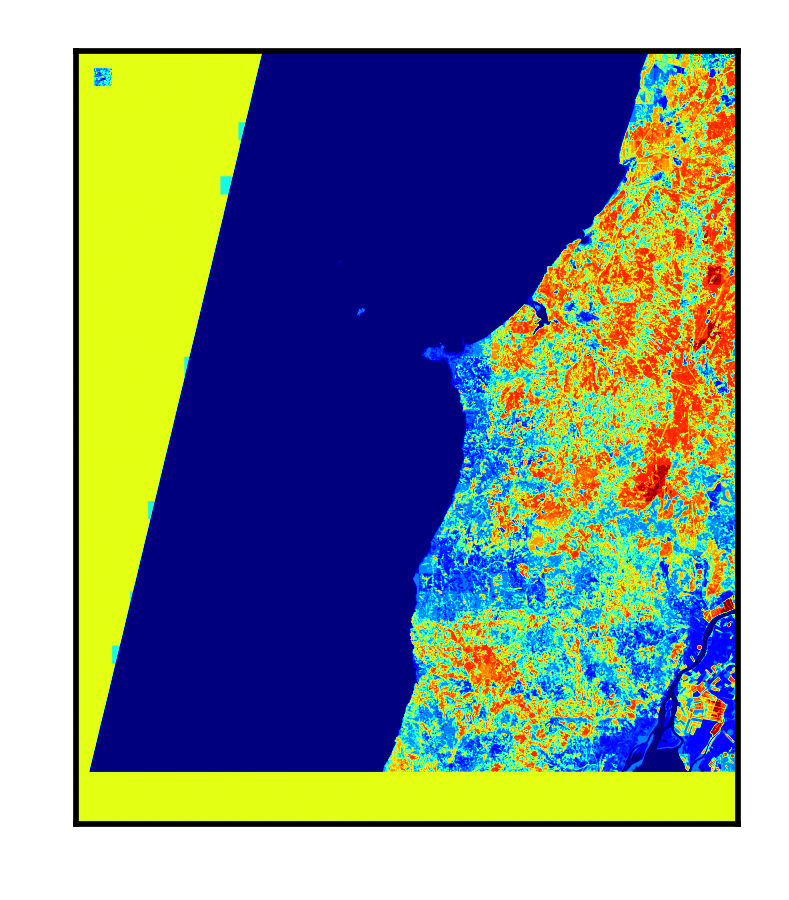

In [ ]:
h,w = image.shape[:2]
visual(1,1,1,image.reshape((h,w)))

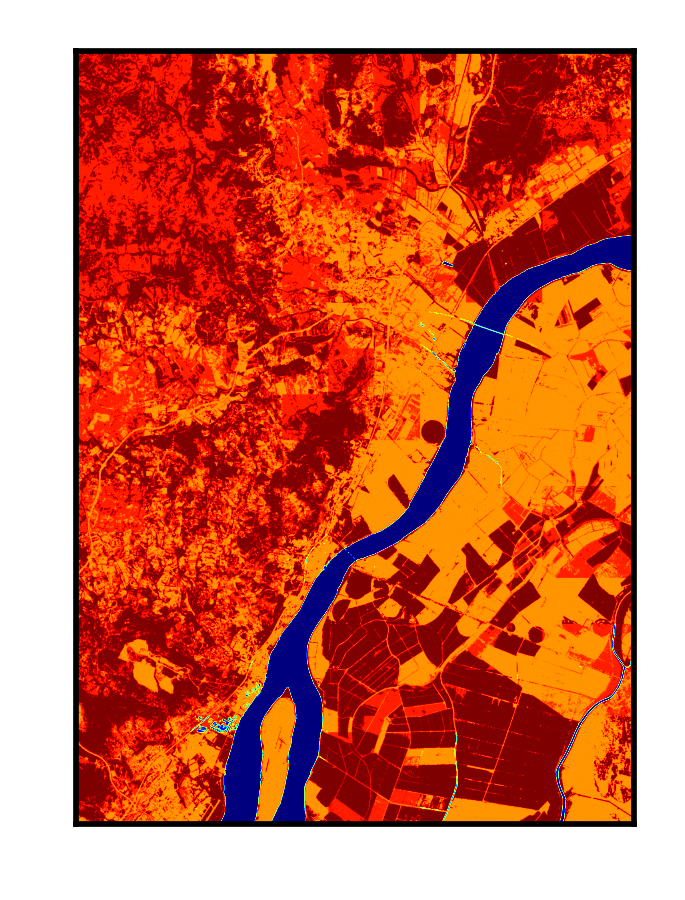

In [ ]:
h,w = image.shape[:2]
visual(1,1,1,image.reshape((h,w)))

In [ ]:
for i in list(set(image.flatten())):
    mask = np.zeros_like(image)
    mask[image==i] =1
    print(i,":",np.sum(mask))

1.0 : 2557305.0
2.0 : 3801131.0
3.0 : 122809.0
4.0 : 340428.0
7.0 : 3610553.0
8.0 : 27992714.0
9.0 : 82135460.0


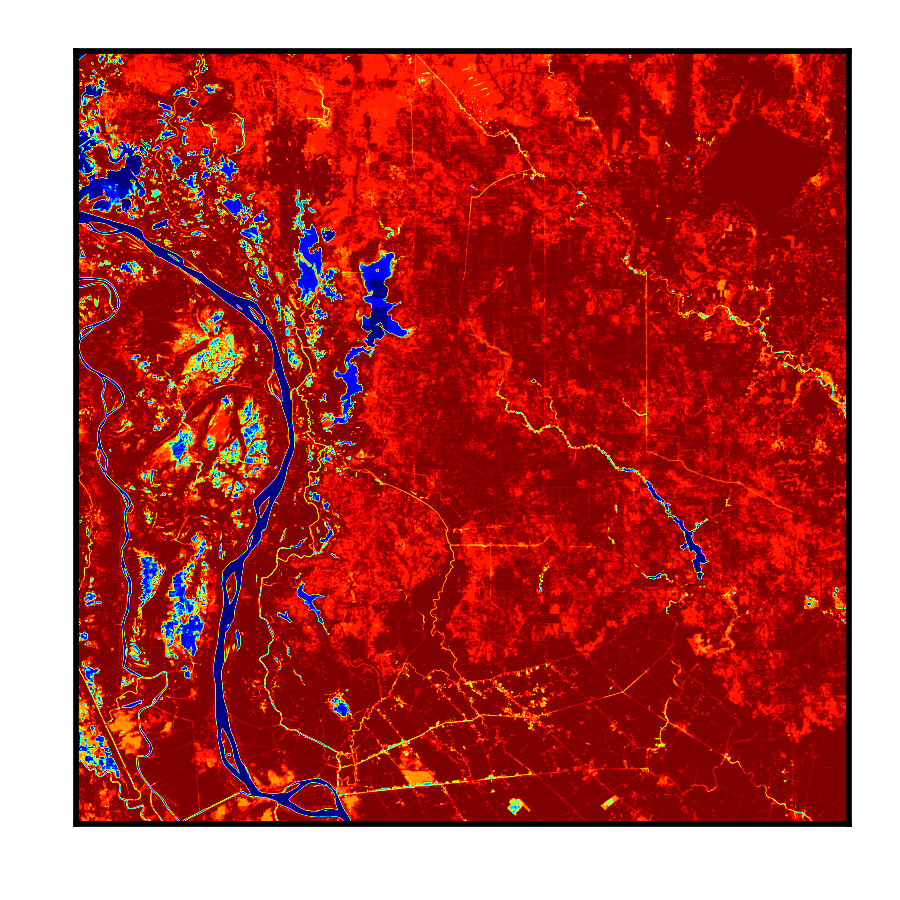

In [ ]:
# for 4 class kmeans ran 4 times aggregated

visual(1,1,1,image.reshape((h,w)))

In [ ]:
# for 4 class kmeans ran 4 times aggregated
for i in list(set(image.flatten())):
    mask = np.zeros_like(image)
    mask[image==i] =1
    print(i,":",np.sum(mask))

1.0 : 4848150.0
2.0 : 1025387.0
3.0 : 7.0
4.0 : 4196668.0
5.0 : 71453.0
7.0 : 5636220.0
8.0 : 14372838.0
9.0 : 90409677.0


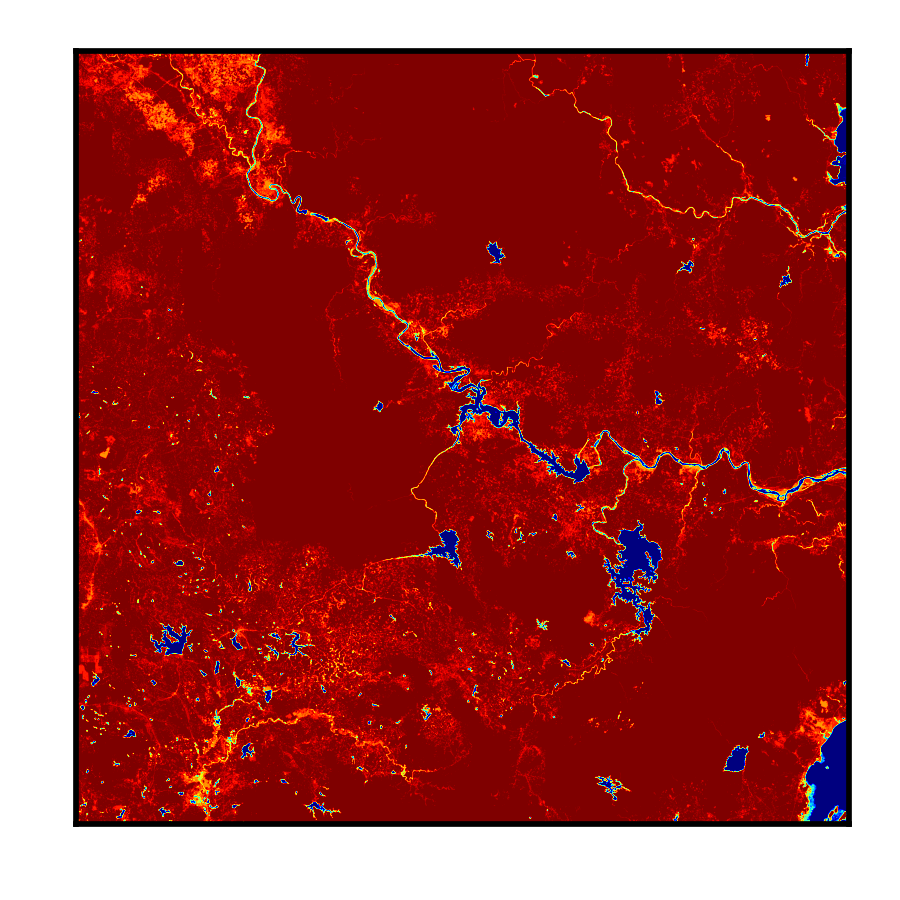

In [ ]:
# for kmeans output best1
folder_img = '/content/drive/My Drive/Excel/vietnam train images'
flist,fnamelist = ((get_all_images(folder_img, 'img')))
folder_label = '/content/drive/My Drive/Excel/kmean_gpu_pred1'
flist2,fnamelist2 = ((get_all_images(folder_label, 'tif')))
nClasses =10
for f,fns in enumerate(flist2[9:10]):
    raster = gdal.Open(fns)
    w,h = round(raster.RasterXSize), round(raster.RasterYSize)
    label = raster2array(raster,1,0,0,w,h)
    raster = None

visual(1,1,1,label.reshape((label.shape[1],label.shape[0])))
del label

In [ ]:
# fpath = '/content/drive/My Drive/Excel/vietnam images/t48pwt_20190106_re.img'
folder_img = '/content/drive/My Drive/Portugal/landsat'
flist,fnamelist = ((get_all_images(folder_img, 'tif')))
raster = gdal.Open(flist[0])
w,h = round(raster.RasterXSize), round(raster.RasterYSize)
##########image1 = (raster2array(raster,4,0,0,w,h)).astype(np.uint8)
image1 = (raster2array(raster,4,0,0,w,h)).astype(np.uint16)
raster = None       


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


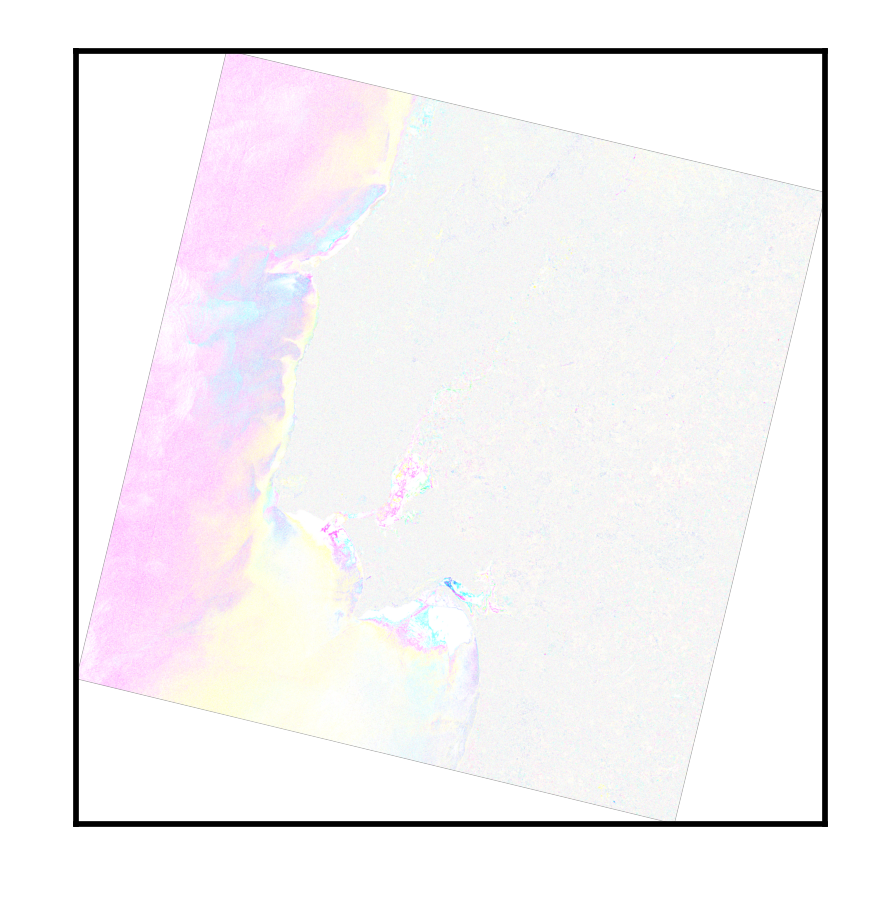

In [ ]:
visual(1,1,1,image1*255/5000)

In [ ]:
path = '/content/drive/My Drive/Excel/kmeans_gpu_pred1/t48pyb_20181102_re_pred1.tif'
image = 

In [ ]:

def custom_sort(arr):
    sorted = arr.sort()
    for i in range(1,len(arr)-1,2):
        temp = arr[i]
        arr[i] = arr[i+1]
        arr[i+1] = temp
    return arr

In [ ]:
arr = [1,4,7,11,13,14,17,18,19,21,23]
arr.reverse()
custom_sort(arr)

[1, 7, 4, 13, 11, 17, 14, 19, 18, 23, 21]

In [ ]:
arr = [1,8,7,11,54,14,108,20]
arr.reverse()
custom_sort(arr)

[1, 8, 7, 14, 11, 54, 20, 108]